In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../../data/train.csv')

/var/folders/d0/392xlklj0d556sxmtxfd01n00000gn/T/ipykernel_47736/497448432.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../../data/train.csv')


In [3]:
from implicit.bpr import BayesianPersonalizedRanking

In [4]:
model = BayesianPersonalizedRanking(random_state=42)

In [5]:
train.head()

,user_id,movie_id,rating,timestamp,datetime,title,genres,gender,age,occupation,zip_code
0,6040,858,4,956703932,2000-04-26 08:05:32,"Godfather, The (1972)",Action|Crime|Drama,M,25,6,11106
1,6040,593,5,956703954,2000-04-26 08:05:54,"Silence of the Lambs, The (1991)",Drama|Thriller,M,25,6,11106
2,6040,2384,4,956703954,2000-04-26 08:05:54,Babe: Pig in the City (1998),Children's|Comedy,M,25,6,11106
3,6040,1961,4,956703977,2000-04-26 08:06:17,Rain Man (1988),Drama,M,25,6,11106
4,6040,2019,5,956703977,2000-04-26 08:06:17,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,M,25,6,11106


In [6]:
train_df = train.set_index(['user_id', 'movie_id'])['rating'].unstack('movie_id')

In [7]:
train_df.shape

(5347, 3661)

In [8]:
# 本当はこれでNaNは無視, スコアが1離れているものをペアとしてサンプリングして損失を計算するとやりたいがimplicitでは無理そう
train_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
690,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# とりあえずimplicitに合わせて学習と予測をしてみる
train_df = train_df.fillna(0)
train_matrix = train_df.values

In [11]:
train_matrix[train_matrix<=2] = 0
train_matrix[train_matrix>2] = 1

In [12]:
from scipy.sparse import csr_matrix

In [13]:
train_matrix = csr_matrix(train_matrix)

In [14]:
model.fit(train_matrix)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
pred_df = pd.DataFrame(model.user_factors.dot(model.item_factors.T), index=train_df.index, columns=train_df.columns)

In [19]:
pred_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
688,0.292199,-0.592515,-0.610691,-1.655056,-0.845409,-0.743834,-1.340001,-0.064640,-1.365462,-0.885429,...,0.023804,0.094886,0.021036,0.153582,0.508762,0.123904,0.070622,0.654207,0.016059,0.227957
689,-1.842675,0.198673,1.995023,2.633283,1.016169,-2.084604,3.449902,-0.782871,-0.493698,-0.242961,...,0.709723,0.252083,0.863846,-0.223509,1.247433,-0.316377,0.227505,0.520863,0.932984,0.139073
690,2.667878,0.264233,-0.076474,-1.538034,-0.210947,-0.545654,0.058851,-0.372127,-2.433301,-1.071024,...,-1.244516,-0.092078,0.111800,-1.084506,-1.768036,0.266869,-1.424415,-0.963505,-1.746818,-0.950956
691,0.742934,-1.289570,-1.941690,-2.156702,-2.290190,-0.325812,-1.821226,-1.017352,-3.166859,-1.319151,...,0.507514,-0.128373,-0.499152,-0.900221,0.294171,-0.857476,0.583754,0.752921,0.255111,-0.116880
692,0.210588,-0.537444,-0.372968,-0.603233,-0.248592,0.773246,-0.807767,-0.396919,-1.004412,-0.389743,...,-0.064690,0.010599,-0.147164,-0.077516,-0.147113,0.202697,0.068093,0.459686,0.353561,0.604751


In [20]:
test = pd.read_csv('../../data/test.csv')

In [21]:
test.head()

,user_id,movie_id,rating,timestamp,datetime,title,genres,gender,age,occupation,zip_code
0,4802,3176,5,975597034,2000-12-01 00:10:34,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,M,56,1,40601
1,4802,1589,2,975597114,2000-12-01 00:11:54,Cop Land (1997),Crime|Drama|Mystery,M,56,1,40601
2,4802,3044,5,975597114,2000-12-01 00:11:54,Dead Again (1991),Mystery|Romance|Thriller,M,56,1,40601
3,1218,1892,3,975598054,2000-12-01 00:27:34,"Perfect Murder, A (1998)",Mystery|Thriller,M,56,15,13207
4,2307,858,5,975598321,2000-12-01 00:32:01,"Godfather, The (1972)",Action|Crime|Drama,M,25,17,02140


In [30]:
pred = []
for uid, mid in zip(test['user_id'], test['movie_id']):
    if uid in pred_df.index and mid in pred_df.columns:
        pred.append(pred_df.loc[uid, mid])
    else:
        pred.append(np.nan)

In [31]:
test['pred'] = pred

In [32]:
eval_df = test.loc[test['pred'].notnull(), ['user_id', 'movie_id', 'rating', 'pred']].copy()

In [35]:
from sklearn.metrics import ndcg_score

In [38]:
scores = []
for _, gr in eval_df.groupby('user_id'):
    if len(gr) > 1:
        ndcg = ndcg_score(np.asarray([gr['rating']]), np.asarray([gr['pred']]))
        scores.append(ndcg)

<Axes: >

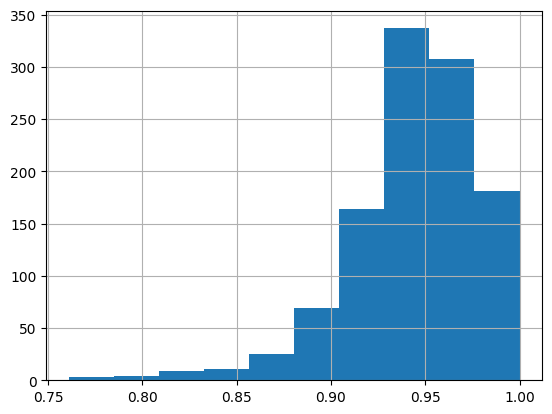

In [39]:
pd.Series(scores).hist()

In [40]:
pd.Series(scores).describe()

count    1111.000000
mean        0.944101
std         0.035277
min         0.760910
25%         0.927369
50%         0.949089
75%         0.966662
max         1.000000
dtype: float64